# Sensor Data Fusion
Lecturer: Prof. Baum \
Tutor: Dr. Kolja Thormann\
Semester: Summer 2024
## Homework 9

Assume again a robot in 2D-space at position $\begin{bmatrix}x_1 & x_2\end{bmatrix}^T$ moving with velocity $\dot{x}_1$ in $x_1$ direction and $\dot{x}_2$ in $x_2$ direction. Its state is defined as $\textbf{x}=\begin{bmatrix}x_1 & x_2 & \dot{x}_1 & \dot{x}_2\end{bmatrix}^T$. Assume the prior distribution has mean $\hat{\textbf{x}}_0=\begin{bmatrix}0 & 0 & 5 & 0\end{bmatrix}^T$ and covariance $\textbf{C}_{\textbf{x},0}=\text{diag}(\begin{bmatrix}0.5 & 0.5 & 0.1 & 0.1\end{bmatrix})$.

---
The following tasks will have missing sections marked that you should fill out. 

Missing code parts are marked by
```
# ... code code code
=== YOUR CODE HERE ===

=== END OF YOUR CODE ===
# ... code code code
```
If you are asked to implement a function, make sure to check what variable will be returned by the function and to fill it accordingly. Do not change code outside of the indicated sections.

Furthermore, some questions require theoretical answers instead of python code.

Such questions will have a field marked like this: 

=== YOUR ANSWER HERE === 

In [2]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [3]:
# prior
prior_mean = np.array([0, 0, 5, 0])  # inital mean for x
prior_cov = np.array([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
])

---
### a)

Assume the accelerations in $x_{1/2}$ direction $a_{1/2}$ are modeled by zero mean white noise, i.e., $a_{1/2}\sim\mathcal{N}(0, \sigma_a^2)$. Both $a_1$ and $a_2$ are independent, have the same variance $\sigma_a^2$, and are constant over an entire time step with length $T$. Write a function which moves the state $T$ seconds into the future. Then, write a simulation which
- samples the true state from the prior,
- moves the state $T=2$ second into the future, drawing and adding noise with variance $\sigma_a^2=0.25$ appropriately, and
- repeats this process $N=200$ times and visualizes the positions after $T$ seconds for each run.

In [4]:
# simulation parameters
noise_variance = 0.25
T = 2
N = 200

In [5]:
def sample_prior(mean, cov):
    """
    Function  to sample a true position from the prior distribution.
    :param mean: the 4D mean of the prior distribution
    :param cov:  the 4x4 covariance of the prior distribution
    :return:      an array of length len(mean)
    """
    # === YOUR CODE HERE ===

    sample = np.random.multivariate_normal(mean, cov)
    # === END OF YOUR CODE ===

    return sample


def motion_model(state, noise_variance, T):
    """
    Function to move the state ts seconds into the future.
    :param state:          the 4D state consisting of 2D position and 2D velocity
    :param noise_variance: the scalar noise variance of the acceleration in both dimensions
    :param T:              the length of the time step
    :return:               the state after the motion
    """
    # === YOUR CODE HERE ===

    new_state = state + np.array([state[2], state[3], np.random.normal(0, noise_variance), np.random.normal(0, noise_variance)]) * T

    # === END OF YOUR CODE ===

    return new_state

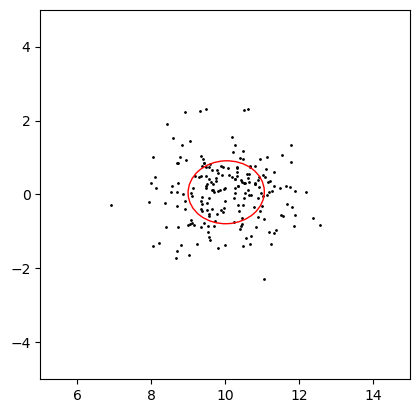

In [6]:
def simulate_motion(prior_mean, prior_cov, noise_variance, T, N):
    """
    Simulates a motion for time difference T of a state drawn from a prior distribution. Repeats the process N times and returns the results.
    :param prior_mean:     the 4D mean of the prior distribution
    :param prior_cov:      the 4x4 covariance of the prior distribution
    :param noise_variance: the scalar noise variance of the acceleration in both dimensions
    :param T:              the length of the time step
    :param N:              number of simulation runs
    :return:               a nX4 array of the states afters the motion of each simulation run
    """
    new_states = np.zeros((N, 4))

    # === YOUR CODE HERE ===
    new_states = np.array([motion_model(sample_prior(prior_mean, prior_cov), noise_variance, T) for _ in range(N)])


    # === END OF YOUR CODE ===

    return new_states


def visualize_covariance(C, m, **kwargs):
    """
    Adds a visualization of a covariance matrix as an ellipse to the current matplotlib plot.
    :param C: Covariance matrix
    :param m: Mean
    :param color: color to draw in (for matplotlib)
    """
    # ensure everything is numpy
    C = np.array(C)
    m = np.array(m)
    
    eig_vals, eig_vecs = np.linalg.eig(C)
    psi = np.arctan2(eig_vecs[1, 0], eig_vecs[0, 0])
    ell = Ellipse(xy=m, width=2.0*np.sqrt(eig_vals[0]), height=2.0*np.sqrt(eig_vals[1]), angle=np.rad2deg(psi), fill=False, **kwargs)
    plt.gca().add_artist(ell)


def plot_state_positions(states, mean=None, cov=None):
    """
    Plots the distribution of states' positions. Optionally, plots the Gaussian state distribution described by mean and cov.
    :param states: Nx4 array consisting of N state, each of which has its position as the first 2 dimensions
    :param mean:   (optional) mean of a Gaussian representing a distribution of possitble states
    :param cov:    (optional) covariance of a Gaussian representing a distribution of possible states
    """
    plt.scatter(states[:, 0], states[:, 1], s=1, c='black')

    state_mean = np.mean(states, axis=0)
    scatter_matrix = np.einsum('xn, xm -> nm', state_mean[None, :] - states, state_mean[None, :] - states) / (len(states)-1)
    visualize_covariance(scatter_matrix, state_mean, color='red')

    if (mean is not None) and (cov is not None):
        visualize_covariance(cov[:2, :2], mean[:2], color='blue')

    plt.axis([5, 15, -5, 5])
    plt.gca().set_aspect("equal")
    plt.show()


states = simulate_motion(prior_mean, prior_cov, noise_variance, T, N)
plot_state_positions(states)

---
### b)

Now implement the Kalman filter prediciton formulas for the corresponding motion model. Compare the resulting Gaussian distribution of the state position with the distribution of the positions from the simulation.

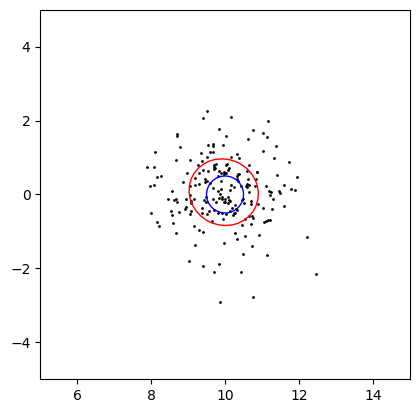

In [13]:
def kalman_prediction(mean, cov, noise_variance, T):
    """
    Predict the state distribution for a time difference of T into the future, considering acceleration noise.
    :param mean:           the 4D mean of the state distribution
    :param cov:            the 4x4 covariance of the state distribution
    :param noise_variance: the scalar noise variance of the acceleration in both dimensions
    :param T:              the length of the time step
    :param N:              number of simulation runs
    :return:               the 4D mean and 4x4 covariance of the predicted state distribution after the motion
    """
    # === YOUR CODE HERE ===

    new_mean = np.array([mean[0] + mean[2]*T, mean[1] + mean[3]*T, mean[2], mean[3]])
    new_cov = cov @ np.array([[1, 0, T, 0], [0, 1, 0, T], [0, 0, 1, 0], [0, 0, 0, 1]]) @ cov.T + np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, noise_variance, 0], [0, 0, 0, noise_variance]])
    
    # === END OF YOUR CODE ===

    return new_mean, new_cov


new_mean, new_cov = kalman_prediction(prior_mean, prior_cov, noise_variance, T)

states = simulate_motion(prior_mean, prior_cov, noise_variance, T, N)
plot_state_positions(states, new_mean, new_cov)